In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from loaddatastructs import *
from helperfuncs import *
from plottingfuncs import *
from matplotlib.colors import LogNorm

In [2]:
Archive.archive_path = '/data/keeling/a/sf20/e/wrf-partmc-gridded-output'
Archive.gridsize = 100

Archive.addScenario(scenario_name='uniform-basecase', slurm_id=9349651)
Archive.addScenario(scenario_name='Base case', slurm_id=9349653)  # point-source-1x1

Archive.archive_path = '/data/keeling/a/sf20/e/atms405-final-project-data'
Archive.addScenario(scenario_name="$\\theta'^{-}$, $u=0$", slurm_id=9352740)
Archive.addScenario(scenario_name="$\\theta'^{+}$, $u=0$", slurm_id=9354621)
Archive.addScenario(scenario_name="$\\theta'^{-}$, $u_{shear}$", slurm_id=9352739)
Archive.addScenario(scenario_name="$\\theta'=0$, $u_{shear}$", slurm_id=9351321)
Archive.addScenario(scenario_name="$\\theta'^{+}$, $u_{shear}$", slurm_id=9351328)

scenarios = Archive.getScenarioList()
scenarios.remove('uniform-basecase')

format_scenario_labels = {'point-source-1x1-nt': "$\\theta'^{-}$, $u=0$",
                        'point-source-1x1': "Base case",
                        'point-source-1x1-pt': "$\\theta'^{+}$, $u=0$",
                        'point-source-1x1-w-nt': "$\\theta'^{-}$, $u_{shear}$",
                        'point-source-1x1-w': "$\\theta'=0$, $u_{shear}$",
                        'point-source-1x1-w-pt': "$\\theta'^{+}$, $u_{shear}$",
 }

In [25]:
def calculateVarPercentDiff(scenario, variable,  convert_mixing_ratio=False, skip_t0=False):
    array_scenario = calculateVarZT(scenario, variable, convert_mixing_ratio)
    array_basecase = calculateVarZT('point-source-1x1', variable, convert_mixing_ratio)

    if skip_t0:
        array_scenario = array_scenario[1:]
        array_basecase = array_basecase[1:]

    rel_diff = 100*(array_scenario - array_basecase)/array_basecase
    return rel_diff

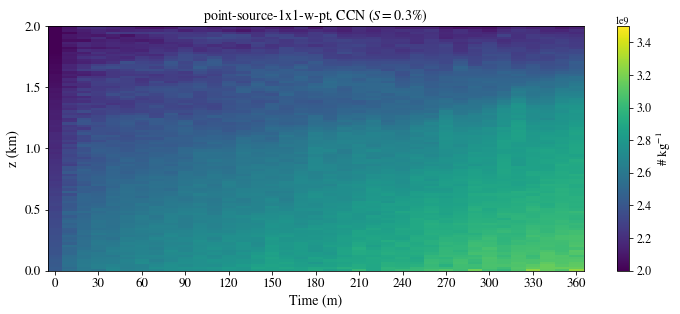

In [22]:
plotZT(scenario='point-source-1x1-w-pt', variable='ccn_003', vmin=2e9, vmax=3.5e9, lognorm=False)

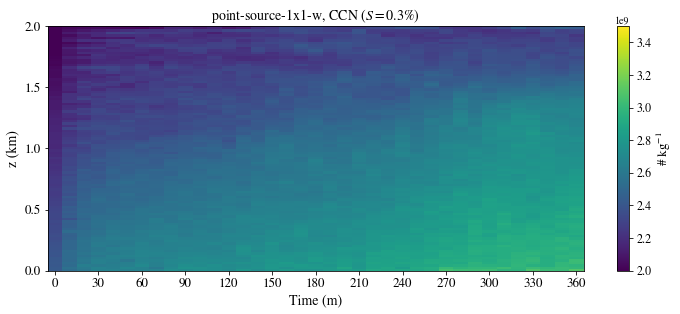

In [21]:
plotZT(scenario='point-source-1x1-w', variable='ccn_003', vmin=2e9, vmax=3.5e9, lognorm=False)

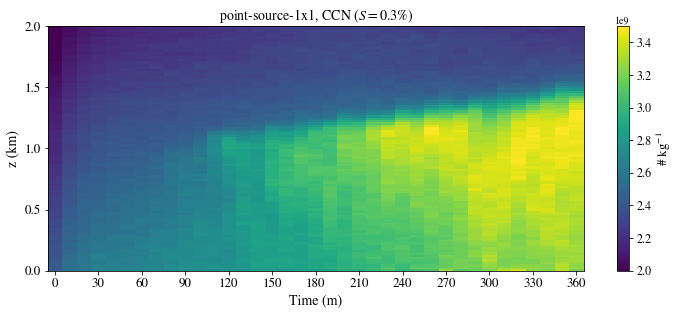

In [20]:
plotZT(scenario='point-source-1x1', variable='ccn_003', vmin=2e9, vmax=3.5e9, lognorm=False)

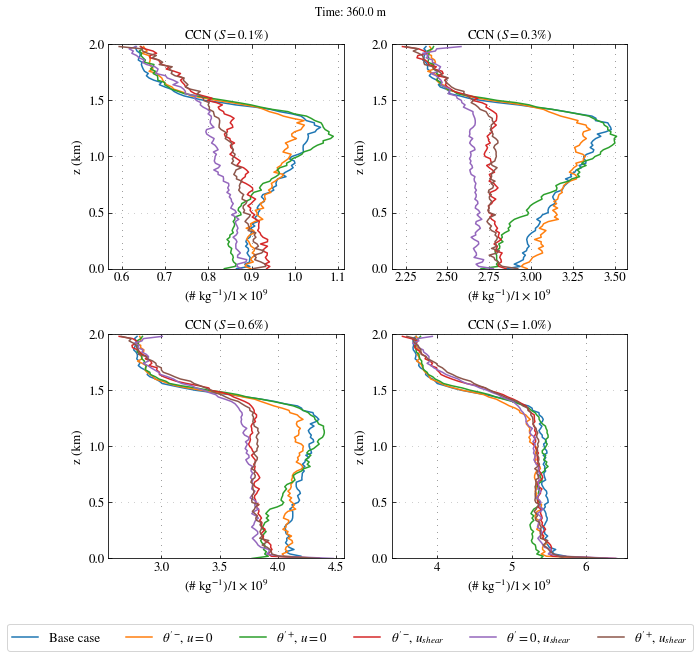

In [21]:
plotScenariosVarsVerticalProfile(scenarios=scenarios, variables=['ccn_001', 'ccn_003', 'ccn_006', 'ccn_010'], time=36, cmap='tab10', unit_prefactor=1e-9, filename='ccn-vertical-profiles.pdf',savefig=True)

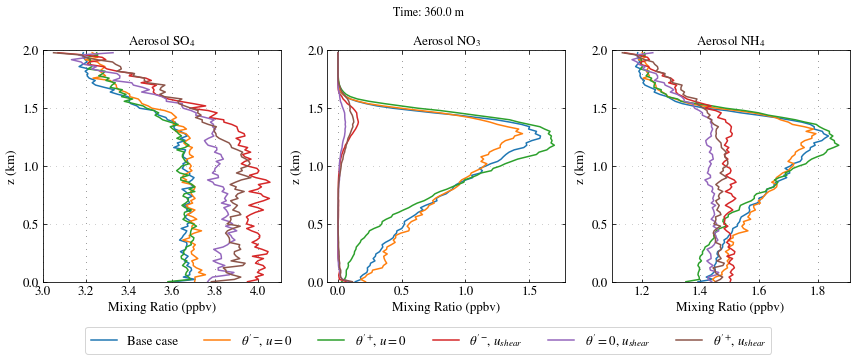

In [20]:
plotScenariosVarsVerticalProfile(scenarios=scenarios, variables=['pmc_SO4', 'pmc_NO3', 'pmc_NH4'], time=36, cmap='tab10', filename='sna-vertical-profiles.pdf', savefig=True)

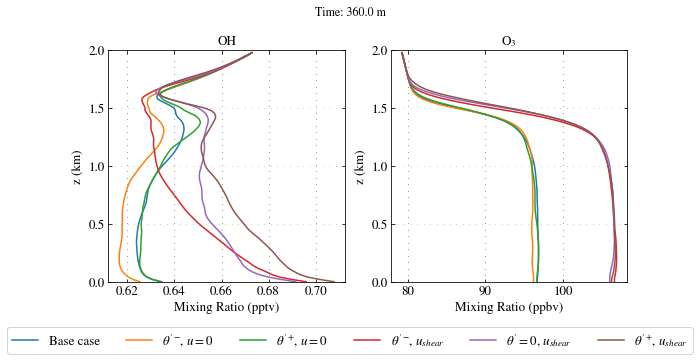

In [22]:
plotScenariosVarsVerticalProfile(scenarios=scenarios, variables=['oh', 'o3'], time=36, cmap='tab10', filename='oxidants-vertical-profiles.pdf',savefig=True)

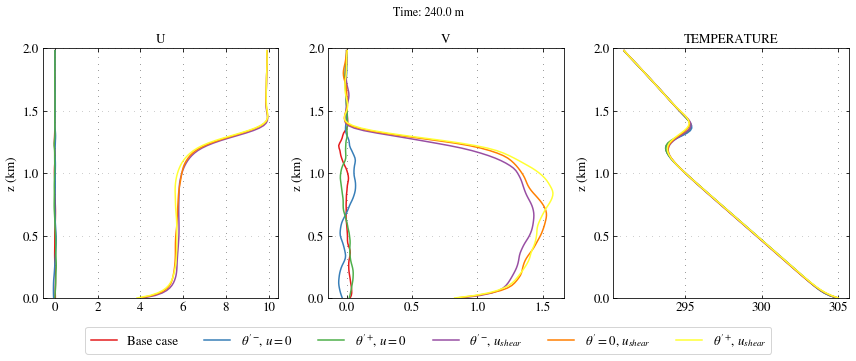

In [7]:
plotScenariosVarsVerticalProfile(scenarios=scenarios, variables=['U', 'V', 'TEMPERATURE'], time=24)

In [3]:
def ClausiusClap(t):
    """Calculate saturation vapor pressure (e_s) in Pa

    Inputs
        t: Temperature in C
    
    Outputs
        Saturation vapor pressure in Pa
    """
    return 611*np.exp((17.27*t)/(237.3+t))

def VaporPressFromRH(RH, T):
    """Compute vapor pressure (e) given RH and temperature
    
    Inputs
        RH: Relative humidity
        T: Temperature in C

    Outputs:
        e: Vapor pressure in Pa
    """
    es = ClausiusClap(T)
    e = (RH*es) / 100
    return e

def SpecificHumidity(T, RH, P):
    """Compute specific humidity (q) given temperature, relative humidity, and pressure

    T: Temperature in C
    RH: Relative humidity (%)
    P: Pressure in Pa
    """
    T = T[:] - 273.15 # convert to C
    epsilon = 0.622 #Mv/Md
    e = VaporPressFromRH(RH, T)
    num = epsilon*e
    denom = P-(1-epsilon)*e
    return num/denom

def VirtualTemp(q, T):
    """Compute virtual temperature

    q: specific humidity (kg/kg)
    T: temperature (K)
    """
    Tv = (1+0.61*q)*T
    return Tv

def Theta(t, p):
    """Compute potential temperature

    t: temperature (K)
    p: pressure (kPa)

    """
    p0 = 1e5 # Pa
    Rd = 287 # J kg^-1 K^-1
    cp = 1005 # J kg^-1 K^-1
    return t*(p0/p)**(Rd/cp)

def ThetaV(tv, p):
    """Compute virtual potential temperature

    tv: virtual temperature (K)
    p: pressure (Pa)
    """
    return Theta(tv, p)

def Richardson(theta_v, z, u, v):
    zs = z[:, 0, :, :].reshape(37, 1, 100, 100)
    us = u[:, 0, :, :-1].reshape(37, 1, 100, 100)
    vs = v[:, 0, :-1, :].reshape(37, 1, 100, 100)

    u = u[:, :, :, :-1]
    v = v[:, :, :-1, :]

    g = 9.81 
    theta_vs = theta_v[:, 0, :, :].reshape(37, 1, 100, 100)
    num = (g/theta_vs[:])*(theta_v[:] - theta_vs[:])*(z[:]-zs)
    denom = (u[:]-us)**2 + (v[:]+vs)**2
    return num/denom


In [7]:
def calculateFluxes(i, u, v, w, thetav):
    """Calculate buoyancy flux
    """
    u0 = u[i, :, : , :-1]
    v0 = v[i, :, :-1 , :]
    w0 = w[i, :-1, : , :]
    thetav0 = thetav[i, :, : , :]

    u0_spatial_mean = u0.mean(axis=(1, 2))
    v0_spatial_mean = v0.mean(axis=(1, 2))
    w0_spatial_mean = w0.mean(axis=(1, 2))
    thetav0_spatial_mean = thetav0.mean(axis=(1, 2))

    u0_spatial_dev = u0 - u0_spatial_mean.reshape(100, 1, 1)
    v0_spatial_dev = v0 - v0_spatial_mean.reshape(100, 1, 1)
    w0_spatial_dev = w0 - w0_spatial_mean.reshape(100, 1, 1)
    thetav0_spatial_dev = thetav0 - thetav0_spatial_mean.reshape(100, 1, 1)

    bouyancy_flx = (thetav0_spatial_dev*w0_spatial_dev).mean(axis=(1, 2))
    return bouyancy_flx

def calculateTKE(i, u, v):
    """Calculate TKE
    """
    u = u[i, :, : , :-1]
    v = v[i, :, :-1 , :]
    
    u_spatial_mean = u.mean(axis=(1, 2))
    v_spatial_mean = v.mean(axis=(1, 2))

    u0_spatial_dev = u - u_spatial_mean.reshape(100, 1, 1)
    v0_spatial_dev = v - v_spatial_mean.reshape(100, 1, 1)

    tke = np.sqrt(u0_spatial_dev**2 + v0_spatial_dev**2).mean(axis=(1, 2))
    return tke

def computeBLHeight(Ri_B_mean, mean_z):
    """Compute the BL height using the method of Seidel et al. 2012

    Determine the first level at which the Richardson number exceeds
    the critical value of 0.25. Then linearly interpolate between this 
    level and the vertical level immediately below to determine the
    height at which R_i = 0.25. 
    """
    R_ic = 0.25
    #d_idx_reset = dataset.reset_index()
    #laminar = d_idx_reset.Height_Hypsom[d_idx_reset.Ri >= R_ic]

    #Ri_idx_above = laminar.index[0]
    Ri_idx_above = np.argmax(Ri_B_mean > R_ic)
    Ri_idx_below = Ri_idx_above - 1

    Ri_height_above = mean_z[Ri_idx_above]
    Ri_height_below = mean_z[Ri_idx_below]

    delta_z = Ri_height_above - Ri_height_below

    Ri_below = Ri_B_mean[Ri_idx_below]
    Ri_above = Ri_B_mean[Ri_idx_above]
    delta_Ri = Ri_above - Ri_below

    slope = (delta_z) / (delta_Ri)

    b = Ri_height_above-slope*Ri_above
    height_Ric = slope*R_ic + b
    return height_Ric, Ri_idx_above


In [5]:
Archive.temp = {}
Archive.press = {}
Archive.rh = {}
Archive.theta = {}
Archive.q = {}
Archive.tv = {}
Archive.thetav = {}
Archive.u = {}
Archive.v = {}
Archive.w = {}
Archive.z = {}
Archive.zmean = {}
Archive.Ri_B = {}
Archive.bouyancy_flx = {}
Archive.tke = {}

for scenario in scenarios:
    print('Processing scenario: ', scenario)
    data = Archive.aero_data[scenario]
    Archive.temp[scenario] = data['TEMPERATURE'] # K
    Archive.press[scenario] = data['PB'][:] + data['P'][:] # Pa
    Archive.rh[scenario] = data['REL_HUMID'] # %

    Archive.theta[scenario] = Theta(Archive.temp[scenario], Archive.press[scenario])
    Archive.q[scenario] = SpecificHumidity(T=Archive.temp[scenario], P=Archive.press[scenario], RH=Archive.rh[scenario])
    Archive.tv[scenario] = VirtualTemp(Archive.q[scenario], Archive.temp[scenario])
    Archive.thetav[scenario] = ThetaV(Archive.tv[scenario], Archive.press[scenario])
    Archive.z[scenario] = data['Z'][:]
    Archive.z[scenario][0, :, :, :] = Archive.z[scenario][1, :, :, :]
    Archive.zmean[scenario] = Archive.z[scenario].mean(axis=(0, 2, 3))
    Archive.u[scenario] = data['U'][:]
    Archive.v[scenario] = data['V'][:]
    Archive.w[scenario] = data['W'][:]

    Archive.Ri_B[scenario] = Richardson(Archive.thetav[scenario], Archive.z[scenario], Archive.u[scenario], Archive.v[scenario])

    #Archive.bouyancy_flx[scenario] = np.array([calculateFluxes(i, Archive.u[scenario], Archive.v[scenario], Archive.w[scenario], Archive.thetav[scenario]) for i in range(37)])
    #Archive.tke[scenario] = np.array([calculateTKE(i, Archive.u[scenario], Archive.v[scenario]) for i in range(37)])


Processing scenario:  Base case
Processing scenario:  $\theta'^{-}$, $u=0$
Processing scenario:  $\theta'^{+}$, $u=0$
Processing scenario:  $\theta'^{-}$, $u_{shear}$
Processing scenario:  $\theta'=0$, $u_{shear}$
Processing scenario:  $\theta'^{+}$, $u_{shear}$


In [26]:
scenario = 'point-source-1x1-w-pt'

# compute deltas from 0 to i-1
t = 36
mean_thetav = Archive.thetav[scenario][t, :, :, :].mean(axis=(1, 2))
delta_mean_thetav = mean_thetav[1:] - mean_thetav[:-1]  

mean_z = Archive.z[scenario][t, :, :, :].mean(axis=(1, 2))
delta_mean_z = mean_z[1:] - mean_z[:-1]

mean_u = Archive.u[scenario][t, :, :, :].mean(axis=(1, 2))
delta_mean_u = mean_u[1:] - mean_u[:-1]

mean_v = Archive.v[scenario][t, :, :, :].mean(axis=(1, 2))
delta_mean_v = mean_v[1:] - mean_v[:-1]

g= 9.81 
num = g*delta_mean_thetav*delta_mean_z
denom = mean_thetav[:-1]*(delta_mean_u**2 + delta_mean_v**2)

Ri_B = num/denom

In [11]:
format_scenario_labels = {'point-source-1x1-nt': "$\\theta'^{-}$, $u=0$",
                        'point-source-1x1': "Base case",
                        'point-source-1x1-pt': "$\\theta'^{+}$, $u=0$",
                        'point-source-1x1-w-nt': "$\\theta'^{-}$, $u_{shear}$",
                        'point-source-1x1-w': "$\\theta'=0$, $u_{shear}$",
                        'point-source-1x1-w-pt': "$\\theta'^{+}$, $u_{shear}$",
 }

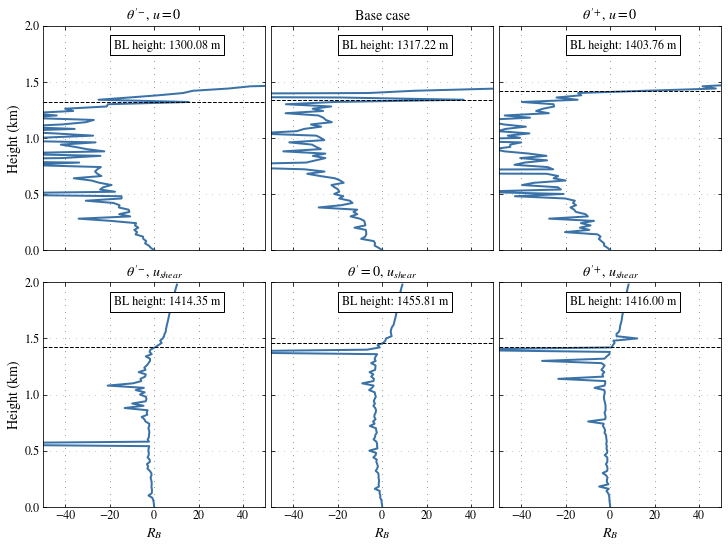

In [8]:
scenarios_ordered = [i for i in format_scenario_labels.values()]
fig, axs = plt.subplots(2, 3, figsize=(10, 7.5), sharex=True, sharey=True, layout='constrained')
for i, (ax, scenario) in enumerate(zip(axs.flatten(), scenarios_ordered)):
    t = 36
    mean_z = Archive.z[scenario][t, :, :, :].mean(axis=(1, 2))
    delta_mean_z = mean_z[1:] - mean_z[:-1]
    """
    mean_thetav = Archive.thetav[scenario][t, :, :, :].mean(axis=(1, 2))
    delta_mean_thetav = mean_thetav[1:] - mean_thetav[:-1]  

    mean_u = Archive.u[scenario][t, :, :, :].mean(axis=(1, 2))
    delta_mean_u = mean_u[1:] - mean_u[:-1]

    mean_v = Archive.v[scenario][t, :, :, :].mean(axis=(1, 2))
    delta_mean_v = mean_v[1:] - mean_v[:-1]

    g= 9.81 
    num = g*delta_mean_thetav*delta_mean_z
    denom = mean_thetav[:-1]*(delta_mean_u**2 + delta_mean_v**2)

    #Ri_B = num/denom

    #ax.plot(Ri_B, np.arange(99), label=scenario, c='#3A72A7', lw=2)
    
    
    """
    Ri_B_mean = Archive.Ri_B[scenario][t, :, :, :].mean(axis=(1, 2))
    ax.plot(Ri_B_mean, np.arange(100), label=scenario, c='#3A72A7', lw=2)
    # get the index of the first value that is greater than 0.25
    #zidx_Ric = np.argmax(Ri_B_mean > 0.25)
    #bl_height = mean_z[np.argmax(Ri_B_mean > 0.25)]

    bl_height, zidx_Ric = computeBLHeight(Ri_B_mean, mean_z)

    ax.axhline(zidx_Ric, xmin=0, xmax=1, color='k', linestyle='--', lw=1)
    ax.text(-18, 90, f'BL height: {bl_height:.2f} m', fontsize=12, bbox=dict(facecolor="white", edgecolor="black"))

    #ax.axvline(0.25, ymin=0, ymax=1, color='r', linestyle='--')
    ax.set_xlim(-50, 50)
    ax.set_ylim(0, 100)
    ax.set_title(scenario, fontsize=14)

    # Set y-axis labels to be height in km
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, Archive.n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))

    # set grid at major ticks
    ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
    ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white')
    ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.tick_params(axis='both', labelsize=12, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    if i % 3 == 0:
        ax.set_ylabel('Height (km)', fontsize=14)
    if i > 2:
        ax.set_xlabel('$R_{B}$', fontsize=14)

plt.savefig('richardson_number_profile.pdf', format='pdf')

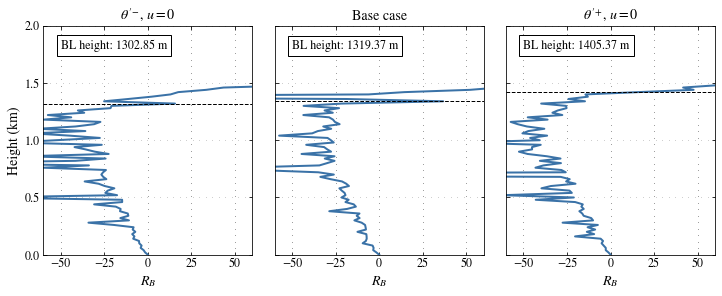

In [9]:
scenarios_ordered = [i for i in format_scenario_labels.values()]
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True, layout='constrained')
for i, (ax, scenario) in enumerate(zip(axs.flatten(), scenarios_ordered[:3])):
    t = 36


    Ri_B_mean = Archive.Ri_B[scenario][t, :, :, :].mean(axis=(1, 2))
    ax.plot(Ri_B_mean, np.arange(100), label=scenario, c='#3A72A7', lw=2)

    # get the index of the first value that is greater than 0.25
    #zidx_Ric = np.argmax(Ri_B_mean > 0.25)
    #bl_height = mean_z[np.argmax(Ri_B_mean > 0.25)]

    bl_height, zidx_Ric = computeBLHeight(Ri_B_mean, mean_z)

    ax.axhline(zidx_Ric, xmin=0, xmax=1, color='k', linestyle='--', lw=1)
    ax.text(-50, 90, f'BL height: {bl_height:.2f} m', fontsize=12, bbox=dict(facecolor="white", edgecolor="black"))

    #ax.axvline(0.25, ymin=0, ymax=1, color='r', linestyle='--')
    ax.set_xlim(-60, 60)
    ax.set_ylim(0, 100)
    ax.set_title(scenario, fontsize=14)

    # Set y-axis labels to be height in km
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, Archive.n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))

    # set grid at major ticks
    ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
    ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white')
    ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.tick_params(axis='both', labelsize=12, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    if i % 3 == 0:
        ax.set_ylabel('Height (km)', fontsize=14)
    #if i > 2:
    ax.set_xlabel('$R_{B}$', fontsize=14)

plt.savefig('richardson_number_profile_1.pdf', format='pdf')

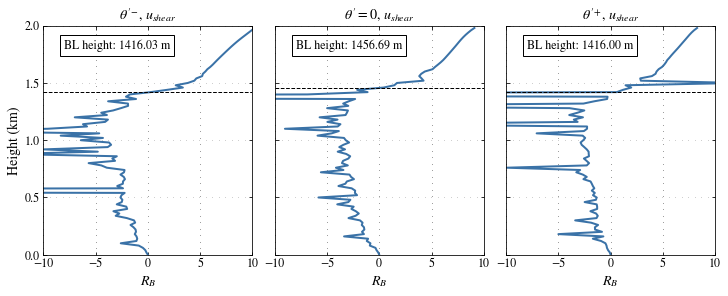

In [10]:
scenarios_ordered = [i for i in format_scenario_labels.values()]
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True, layout='constrained')
for i, (ax, scenario) in enumerate(zip(axs.flatten(), scenarios_ordered[3:])):
    t = 36


    Ri_B_mean = Archive.Ri_B[scenario][t, :, :, :].mean(axis=(1, 2))
    ax.plot(Ri_B_mean, np.arange(100), label=scenario, c='#3A72A7', lw=2)
    # get the index of the first value that is greater than 0.25
    #zidx_Ric = np.argmax(Ri_B_mean > 0.25)
    #bl_height = mean_z[np.argmax(Ri_B_mean > 0.25)]

    bl_height, zidx_Ric = computeBLHeight(Ri_B_mean, mean_z)

    ax.axhline(zidx_Ric, xmin=0, xmax=1, color='k', linestyle='--', lw=1)
    ax.text(-8, 90, f'BL height: {bl_height:.2f} m', fontsize=12, bbox=dict(facecolor="white", edgecolor="black"))

    #ax.axvline(0.25, ymin=0, ymax=1, color='r', linestyle='--')
    ax.set_xlim(-10, 10)
    ax.set_ylim(0, 100)
    ax.set_title(scenario, fontsize=14)

    # Set y-axis labels to be height in km
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, Archive.n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))

    # set grid at major ticks
    ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
    ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white')
    ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.tick_params(axis='both', labelsize=12, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    if i % 3 == 0:
        ax.set_ylabel('Height (km)', fontsize=14)
    #if i > 2:
    ax.set_xlabel('$R_{B}$', fontsize=14)

plt.savefig('richardson_number_profile_2.pdf', format='pdf')

Negative theta perturbation increases the strength of the inversion while the positive theta perturbation has the opposite effect. Minimal changes are observed in the structure of potential temperature throughout the boundary layer itself, whereby the negative theta perturbation induces a slightly cooler boundary layer (by ~-0.02 K) and the positive theta perturbation slightly warms the boundary layer (by ~0.02 K). 

I think the effect of perturbing the initial sounding by +/- 2K is marginal because the increase or decrease in thermal energy is quickly distributed throughout the boundary layer and it readjust to a new thermodynamic equilibirum

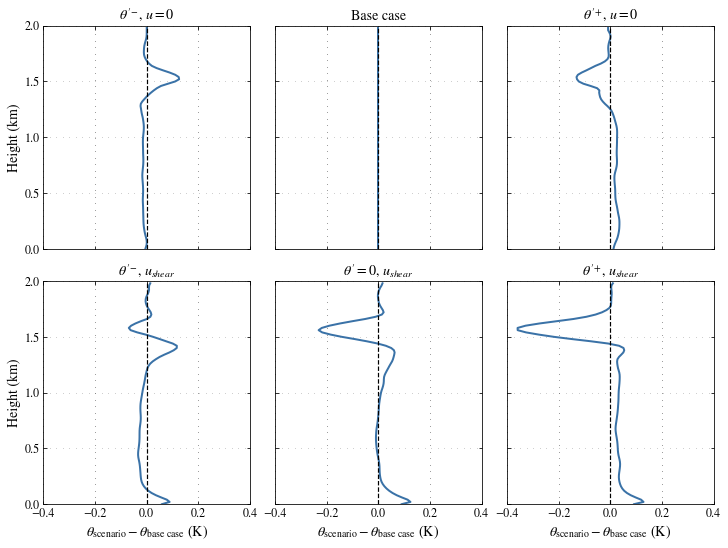

In [ ]:
scenarios_ordered = [i for i in format_scenario_labels.values()]
fig, axs = plt.subplots(2, 3, figsize=(10, 7.5), sharex=True, sharey=True, layout='constrained')

t = 36
mean_thetav_base = Archive.thetav['point-source-1x1'][t, :, :, :].mean(axis=(1, 2))
for i, (ax, scenario) in enumerate(zip(axs.flatten(), scenarios_ordered)):
    
    mean_thetav = Archive.thetav[scenario][t, :, :, :].mean(axis=(1, 2))


    ax.plot(mean_thetav-mean_thetav_base, np.arange(100), label=scenario, c='#3A72A7', lw=2)
    ax.axvline(0, ymin=0, ymax=1, color='k', linestyle='--', lw=1.2)
    ax.set_xlim(-.4, .4)
    ax.set_ylim(-2, 100)
    ax.set_title(scenario)

    # Set y-axis labels to be height in km
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, Archive.n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))

    ax.set_title(scenario, fontsize=14)

    # set grid at major ticks
    ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
    ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white')
    ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.tick_params(axis='both', labelsize=12, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    if i % 3 == 0:
        ax.set_ylabel('Height (km)', fontsize=14)
    if i > 2:
        ax.set_xlabel('$\\theta_{\mathrm{scenario}} - \\theta_{\mathrm{base \ case}}$ (K)', fontsize=14)

plt.savefig('sounding_perturbation_profile.pdf', format='pdf')

In [34]:
scenarios_ordered = [i for i in format_scenario_labels.values()]


In [38]:
"$\\theta'^{-}$, $u=0$" in Archive.thetav.keys()

True

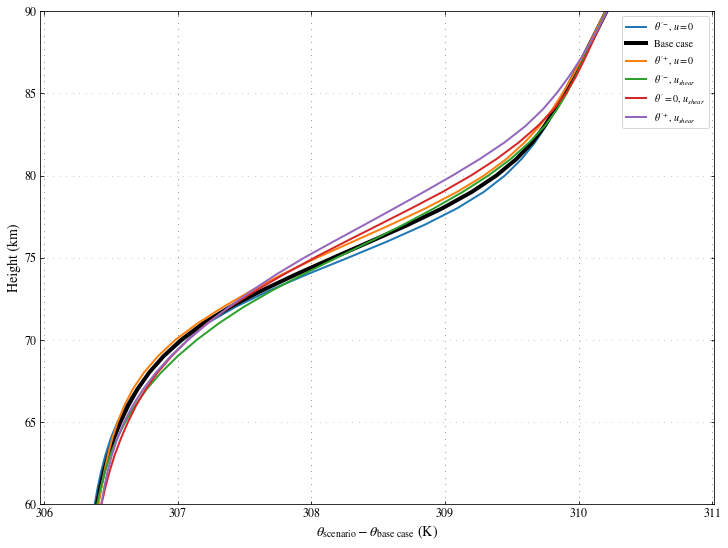

In [50]:
scenarios_ordered = [i for i in format_scenario_labels.values()]
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5), sharex=True, sharey=True, layout='constrained')

t = 36
#mean_thetav_base = Archive.thetav['point-source-1x1'][t, :, :, :].mean(axis=(1, 2))
plt.set_cmap('tab10')
for i, (scenario) in enumerate(scenarios_ordered):
    
    mean_thetav = Archive.thetav[scenario][t, :, :, :].mean(axis=(1, 2))

    if scenario == 'Base case':
        lw = 4
        ax.plot(mean_thetav, np.arange(100), label=scenario, lw=lw,c='k')
    else:
        lw = 2
        ax.plot(mean_thetav, np.arange(100), label=scenario, lw=lw)
    #ax.axvline(0, ymin=0, ymax=1, color='k', linestyle='--', lw=1.2)
    #ax.set_xlim(-.4, .4)
    ax.set_ylim(-2, 100)
    #ax.set_title(scenario)

    # Set y-axis labels to be height in km
    ax.set_ylim(60, 90)
    #ax.set_yticks(np.arange(0, Archive.n_levels+1, 25))
    #ax.set_yticklabels(np.linspace(0, 2, 5).round(2))

    #ax.set_title(scenario, fontsize=14)

    # set grid at major ticks
    ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
    ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white')
    ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.tick_params(axis='both', labelsize=12, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    if i % 3 == 0:
        ax.set_ylabel('Height (km)', fontsize=14)
    if i > 2:
        ax.set_xlabel('$\\theta_{\mathrm{scenario}} - \\theta_{\mathrm{base \ case}}$ (K)', fontsize=14)
ax.legend()
#plt.savefig('sounding_perturbation_profile.pdf', format='pdf')

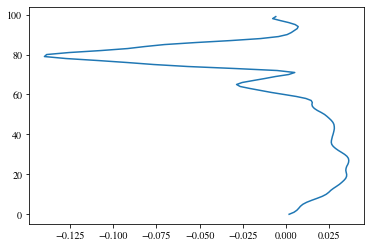

In [83]:
mean_thetav = Archive.thetav['point-source-1x1-w-pt'][t, :, :, :].mean(axis=(1, 2))
mean_thetav_ref = Archive.thetav['point-source-1x1-w'][t, :, :, :].mean(axis=(1, 2))

plt.plot(mean_thetav-mean_thetav_ref, np.arange(100))

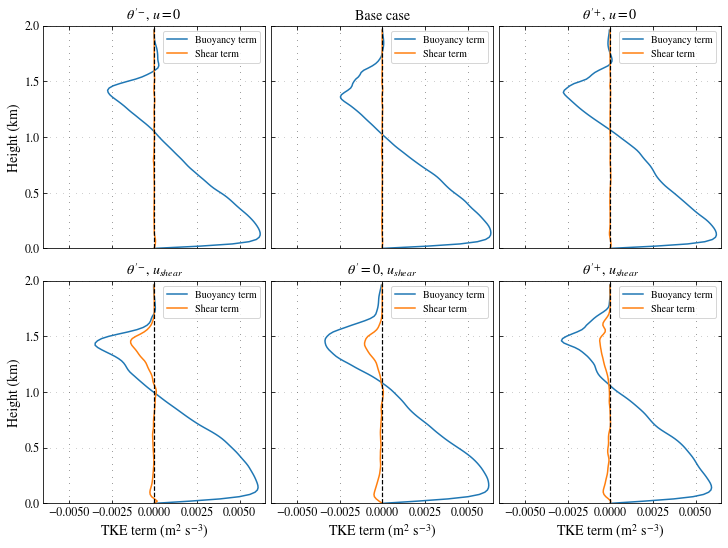

In [27]:
scenarios_ordered = [i for i in format_scenario_labels.values()]
fig, axs = plt.subplots(2, 3, figsize=(10, 7.5), sharex=True, sharey=True, layout='constrained')

t = 36
for i, (ax, scenario) in enumerate(zip(axs.flatten(), scenarios_ordered)):
    
    u = Archive.aero_data[scenario]['U'][t, :, :, :]
    v = Archive.aero_data[scenario]['V'][t, :, :, :]
    w = Archive.aero_data[scenario]['W'][t, :, :, :]
    thetav = Archive.thetav[scenario][t, :, :, :]
    u_spatial_mean = u.mean(axis=(1, 2))
    v_spatial_mean = v.mean(axis=(1, 2))
    w_spatial_mean = w.mean(axis=(1, 2))
    thetav_spatial_mean = thetav.mean(axis=(1, 2))

    u_spatial_dev = u - u_spatial_mean.reshape(100, 1, 1)
    v_spatial_dev = v - v_spatial_mean.reshape(100, 1, 1)
    w_spatial_dev = w - w_spatial_mean.reshape(101, 1, 1)
    thetav_spatial_dev = thetav - thetav_spatial_mean.reshape(100, 1, 1)

    bouyancy_flx = (thetav_spatial_dev*w_spatial_dev[:-1, :, :]).mean(axis=(1, 2))
    zonal_momentum_flx = (u_spatial_dev[:, :, :-1]*w_spatial_dev[:-1, :, :]).mean(axis=(1, 2))
    meridional_momentum_flx = (v_spatial_dev[:, :-1, :]*w_spatial_dev[:-1, :, :]).mean(axis=(1, 2))

    z_mean = Archive.z[scenario][t, :, :, :].mean(axis=(1, 2))
    du_dz = (u_spatial_mean[1:]-u_spatial_mean[:-1])/(z_mean[1:]-z_mean[:-1])
    dv_dz = (v_spatial_mean[1:]-v_spatial_mean[:-1])/(z_mean[1:]-z_mean[:-1])

    g = 9.81 # m/s^2
    tke_bync_term = g*(bouyancy_flx) / thetav_spatial_mean
    tke_shear_term = (zonal_momentum_flx[:-1]*du_dz + meridional_momentum_flx[:-1]*dv_dz)

    """
    tke = np.sqrt(u_spatial_dev[:, :, :-1]**2 + v_spatial_dev[:, :-1, :]**2)
    tke_mean = tke.mean(axis=(1, 2))
    tke_dev = tke - tke_mean.reshape(100, 1, 1)

    vert_tke_flx_mean = (w_spatial_dev[:-1, :, :]*tke_dev).mean(axis=(1, 2))
    d_dz_vert_tke_flx = -1*(vert_tke_flx_mean[1:] - vert_tke_flx_mean[:-1])/(z_mean[1:]-z_mean[:-1])
    """

    """
    p  = Archive.press[scenario][t, :, :, :]
    p_mean = p.mean(axis=(1, 2))
    p_spatial_dev = p - p_mean.reshape(100, 1, 1)
    rho_mean = Archive.aero_data[scenario]['DENSITY_DRY_AIR'][t, :, :, :].mean(axis=(1, 2))
    pressure_correlation = (p_spatial_dev*w_spatial_dev[:-1, :, :]).mean(axis=(1, 2))
    d_dz_pressure_correlation = (pressure_correlation[1:] - pressure_correlation[:-1])/(z_mean[1:]-z_mean[:-1])
    tke_presscorr_term = -1*(1/rho_mean[:-1])*d_dz_pressure_correlation
    """

    ax.plot(tke_bync_term[:-1], np.arange(99), label='Buoyancy term')
    ax.plot(tke_shear_term, np.arange(99), label='Shear term')
    #ax.plot(d_dz_vert_tke_flx, np.arange(99), label='vertical')
    #ax.plot(tke_presscorr_term, np.arange(99), label='pressure')

    ax.axvline(0, ymin=0, ymax=1, color='k', linestyle='--', lw=1.2)
    ax.set_xlim(-.0065, .0065)
    ax.set_ylim(-2, 100)
    ax.set_title(scenario)
    ax.legend()

    # Set y-axis labels to be height in km
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, Archive.n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))

    ax.set_title(scenario, fontsize=14)

    # set grid at major ticks
    ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
    ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white')
    ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.tick_params(axis='both', labelsize=12, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    if i % 3 == 0:
        ax.set_ylabel('Height (km)', fontsize=14)
    if i > 2:
        ax.set_xlabel('TKE term (m$^{2}$ s$^{-3}$)', fontsize=14)

plt.savefig('tke_terms.pdf', format='pdf')

Approximate height of the boundary layer for point-source-1x1: 1361.8978271484375
69
Approximate height of the boundary layer for point-source-1x1-w: 1383.53369140625
70
Approximate height of the boundary layer for point-source-1x1-w-pt: 1321.375732421875
67
Approximate height of the boundary layer for point-source-1x1-w-nt: 1362.2196044921875
69
Approximate height of the boundary layer for point-source-1x1-nt: 1340.72900390625
68
Approximate height of the boundary layer for point-source-1x1-pt: 1279.011962890625
65


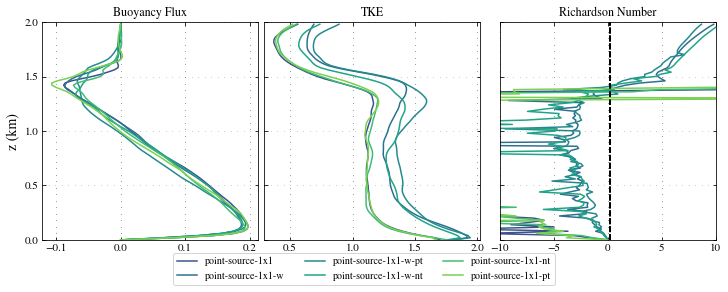

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, layout='constrained')
colors = plt.cm.viridis(np.linspace(.25, .8, len(scenarios)))
t_idx = 35
for i, scenario in enumerate(scenarios):
    axs[0].plot(Archive.bouyancy_flx[scenario][t_idx, :], np.arange(100), color=colors[i])
    axs[1].plot(Archive.tke[scenario][t_idx, :], np.arange(100), color=colors[i])
    
    Ri_B_mean = Archive.Ri_B[scenario][t_idx, :, :, :].mean(axis=(1, 2))
    axs[2].plot(Ri_B_mean, np.arange(100), c=colors[i], label=scenario)
    # get the index of the first value that is greater than 0.25
    zidx_Ric = np.argmax(Ri_B_mean > 0.25)
    print(f'Approximate height of the boundary layer for {scenario}: {Archive.zmean[scenario][zidx_Ric]}')
    print(zidx_Ric)
    #axs[0].axhline(y=zidx_Ric, color=colors[i], linestyle='-') 
    #axs[1].axhline(y=zidx_Ric, color=colors[i], linestyle='-') 
    axs[2].axvline(x=0.25, ymin=0, ymax=1, c='k', ls='--')
    axs[2].set_xlim(-10, 10)

for i in range(3):
    axs[i].set_ylim(0, 100)

    axs[i].set_yticks(np.arange(0, Archive.n_levels+1, 25))
    axs[i].set_yticklabels(np.linspace(0, 2, 5).round(2))

    axs[i].grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
    axs[i].grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white')
    axs[i].grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    axs[i].grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    axs[i].tick_params(axis='both', labelsize=11, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    axs[i].tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

axs[0].set_title('Buoyancy Flux')
axs[1].set_title('TKE')
axs[2].set_title('Richardson Number')

axs[0].set_ylabel('z (km)', fontsize=14)

fig.legend(loc='center', ncol=3, bbox_to_anchor=(.5,-.05))
    

In [35]:

for scenario in scenarios:
    level_mean_Ri_B = Archive.Ri_B[scenario][35, :65, :, :].mean(axis=(1, 2))
    median = np.median(level_mean_Ri_B)
    print(f'Median Richardson number for {scenario}: {median}')

Median Richardson number for point-source-1x1: -27.430609375
Median Richardson number for point-source-1x1-w: -2.843096875
Median Richardson number for point-source-1x1-w-pt: -2.5532064453125
Median Richardson number for point-source-1x1-w-nt: -3.246963671875
Median Richardson number for point-source-1x1-nt: -24.714315625


/data/keeling/a/sf20/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(array([ 1.,  1.,  1.,  1.,  1.,  3.,  7., 23., 14., 13.]),
 array([-114.857475 , -103.3717275,  -91.88598  ,  -80.4002325,
         -68.914485 ,  -57.4287375,  -45.94299  ,  -34.4572425,
         -22.971495 ,  -11.4857475,    0.       ]),
 <BarContainer object of 10 artists>)

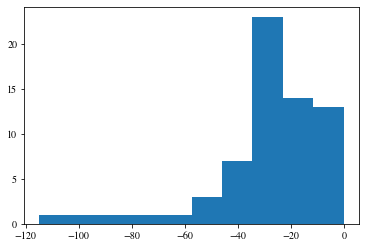

In [36]:
plt.hist(level_mean_Ri_B)

In [11]:
rb_data.shape

(65, 100, 100)

In [67]:
print(scenario)

point-source-1x1-nt


/tmp/ipykernel_75186/1070445085.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.linspace(x_min, x_max, 11))
/tmp/ipykernel_75186/1070445085.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.linspace(0, 2, 5))
/tmp/ipykernel_75186/1070445085.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.linspace(x_min, x_max, 11))
/tmp/ipykernel_75186/1070445085.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.linspace(0, 2, 5))
/tmp/ipykernel_75186/1070445085.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.linspace(x_min, x_max, 11))
/tmp/ipykernel_75186/1070445085.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.linspace(0, 2, 5))
/tmp/ipykernel_75186/1070445085

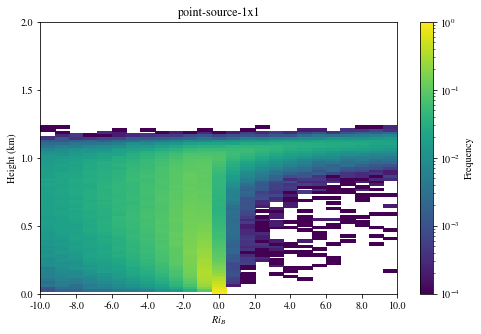

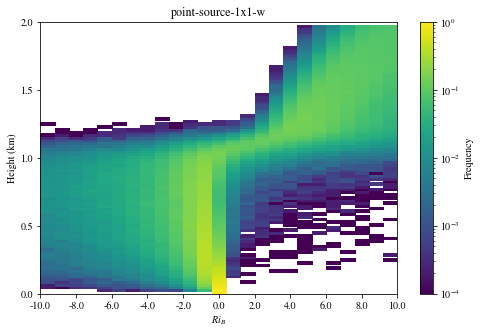

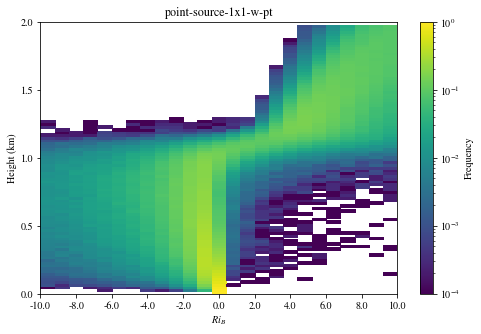

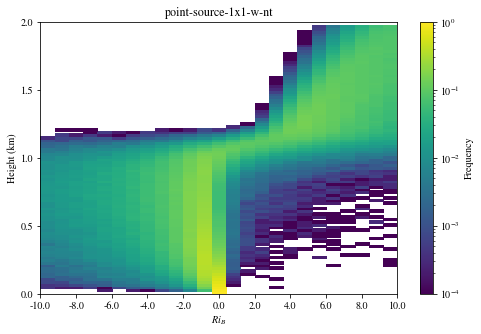

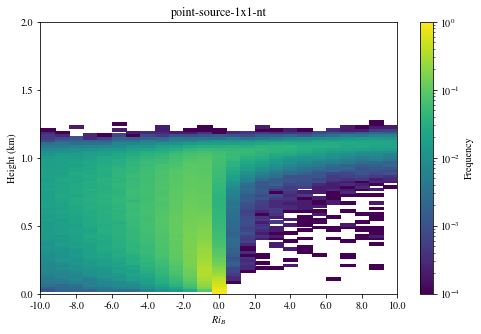

In [186]:
scenario = 'point-source-1x1-w-pt'
for scenario in scenarios:
    rb_data = Archive.Ri_B[scenario][12, :, :, :]

    # Parameters for histogram
    x_bins = 25  # Number of bins for the value range
    y_bins = 99  # Number of bins for the range across the first dimension

    x_min = -10
    x_max = 10

    # Compute pooled values and ranges
    pooled_values = rb_data.reshape(100, 10000).data
    #value_ranges = pooled_values.max(axis=1) - pooled_values.min(axis=1)  # Compute ranges

    # Define bins for the histogram
    #x_edges = np.linspace(rb_data.min(), rb_data.max(), x_bins + 1)
    x_edges = np.linspace(x_min, x_max, x_bins + 1)
    y_edges = np.linspace(0, 100, y_bins + 1)

    # Create a 2D histogram
    histogram = np.zeros((y_bins, x_bins))
    for i, range_val in enumerate(y_edges):
        # Bin the values for the current range
        counts, _ = np.histogram(pooled_values[i], bins=x_edges)
        y_bin = np.digitize(range_val, y_edges) - 1
        if 0 <= y_bin < y_bins:
            histogram[y_bin] += counts

    # Normalize (optional)
    histogram /= histogram.max()

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    #plt.plot(x_bins/2 + rb_data.mean(axis=(1,2)), np.arange(100), color='k', label='Mean')
    #print(rb_data.mean(axis=(1,2)).min())
    
    # Plot the 2D histogram
    c= ax.pcolormesh(histogram, norm=LogNorm(), edgecolor='face', #aspect='auto', 
                #extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], 
                #origin='lower'
                )

    #ax.contour(histogram, levels=np.linspace(.1, 1, 10), colors='k', linewidths=0.5)
    
    ax.set_xticklabels(np.linspace(x_min, x_max, 11))
    ax.set_yticklabels(np.linspace(0, 2, 5))
    ax.set_yticks(np.linspace(0, y_bins+1, 5))
    ax.set_xticks(np.linspace(0, x_bins, 11))
    ax.set_xlim(0, x_bins)
    ax.set_ylim(0, y_bins+1)

    fig.colorbar(c, ax=ax, label='Frequency')
    ax.set_xlabel('$Ri_B$')
    ax.set_ylabel('Height (km)')
    plt.title(f'{scenario}')
    plt.savefig(f'./plots/{scenario}_Ri_B_histogram.pdf', format='pdf')

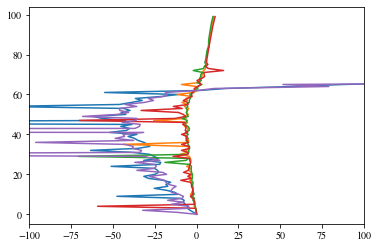

In [184]:
for scenario in scenarios:
    plt.plot(Archive.Ri_B[scenario][24:36, :, :, :].mean(axis=(0, 2,3)), np.arange(100))
    plt.xlim(-100, 100)
